# Result Analysis

## Imports & Inits

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
import torch
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir'),
 'figdir': PosixPath('../data/workdir/figdir'),
 'raw_csv': PosixPath('../data/mimic_icu_pred_raw_dataset.csv'),
 'proc_csv': PosixPath('../data/mimic_icu_pred_proc_dataset.csv'),
 'imminent_threshold': {'lr': 0.47, 'rf': 0.32, 'gbm': 0.3},
 'discharge_threshold': {'lr': 0.48, 'rf': 0.37, 'gbm': 0.39}}

## 100 Run Performance Results

### Imminent ICU Admission

In [4]:
models = list(args.imminent_threshold.keys())

bams = {}

for model in models:
  with open(args.workdir/model/'imminent_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
    
  bams[model] = BinaryAvgMetrics(targs, preds, probs)

all_metrics = {}

for key in bams.keys():
  all_metrics[key] = []
  for i in range(len(bams[key].get_avg_metrics())):
    all_metrics[key].append(bams[key].get_avg_metrics().iloc[i]['Value'])

metrics = pd.DataFrame(all_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
metrics

,lr,rf,gbm
sensitivity,89.3,82.3,81.7
specificity,62.2,73.3,74.4
ppv,42.2,48.8,49.6
auroc,84.2,85.7,86.2
npv,95.0,93.1,93.0
f1,57.3,61.2,61.7


#### Model Plots

In [ ]:
model = 'lr'
bams[model].get_avg_metrics()

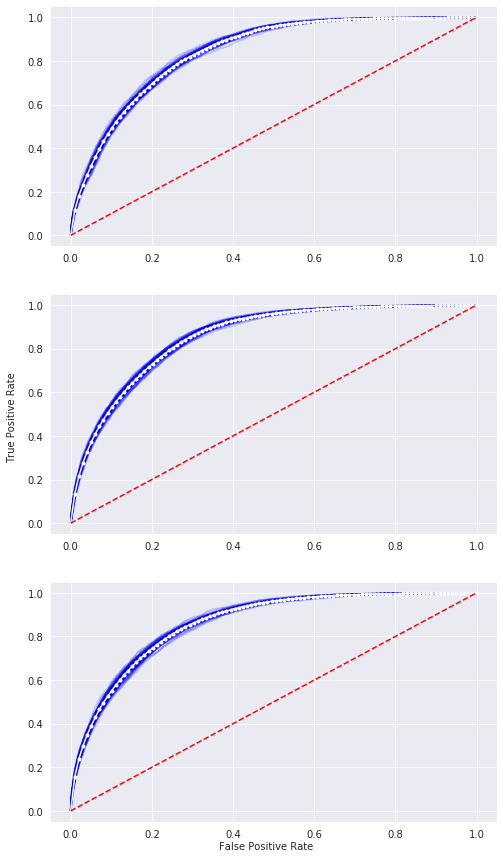

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(8, 15))
plot_mean_roc(ax[0], bams['lr'].targs, bams['lr'].probs)
plot_mean_roc(ax[1], bams['rf'].targs, bams['rf'].probs)
plot_mean_roc(ax[2], bams['gbm'].targs, bams['gbm'].probs)

fig.text(0.5, 0.1, 'False Positive Rate', ha='center')
fig.text(0.05, 0.5, 'True Positive Rate', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.2)

In [ ]:
# fig.savefig(args.figdir/f'{model}_mean_roc.tif', dpi=300)

### ICU Dishcarge

In [29]:
models = list(args.discharge_threshold.keys())

bams = {}

for model in models:
  with open(args.workdir/model/'discharge_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
    
  bams[model] = BinaryAvgMetrics(targs, preds, probs)

all_metrics = {}

for key in bams.keys():
  all_metrics[key] = []
  for i in range(len(bams[key].get_avg_metrics())):
    all_metrics[key].append(bams[key].get_avg_metrics().iloc[i]['Value'])

metrics = pd.DataFrame(all_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
metrics

,lr,rf,gbm
sensitivity,71.4,78.2,79.4
specificity,63.7,61.0,63.0
ppv,53.1,53.6,55.3
auroc,74.9,78.6,80.1
npv,79.4,82.9,84.1
f1,60.9,63.6,65.2


#### Model Plots

In [30]:
model = 'lr'
bams[model].get_avg_metrics()

,Value
sensitivity,71.4
specificity,63.7
ppv,53.1
auroc,74.9
npv,79.4
f1,60.9


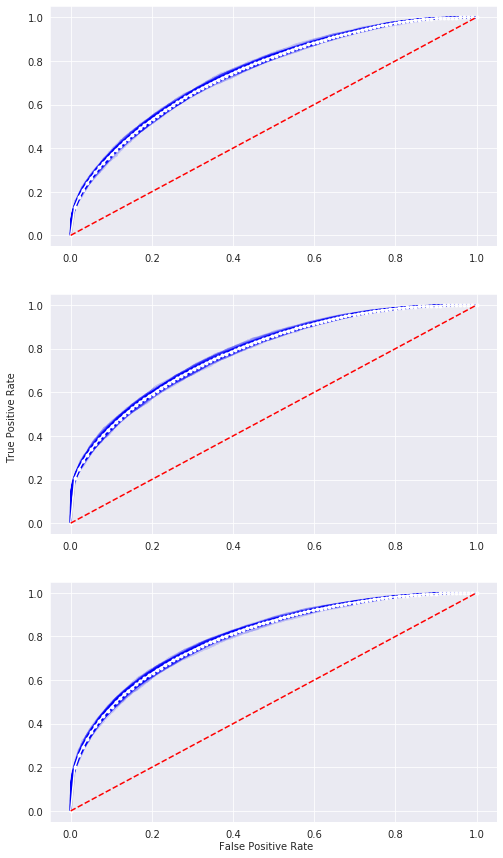

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(8, 15))
plot_mean_roc(ax[0], bams['lr'].targs, bams['lr'].probs)
plot_mean_roc(ax[1], bams['rf'].targs, bams['rf'].probs)
plot_mean_roc(ax[2], bams['gbm'].targs, bams['gbm'].probs)

fig.text(0.5, 0.1, 'False Positive Rate', ha='center')
fig.text(0.05, 0.5, 'True Positive Rate', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.2)

In [ ]:
# fig.savefig(args.figdir/f'{model}_mean_roc.tif', dpi=300)

## Temporal Performance Analysis

In [ ]:
df = pd.read_csv(args.dataset_csv, parse_dates=['admittime', 'dischtime', 'intime', 'charttime'])
df['relative_charttime'] = (df['charttime'] - df['intime'])
print(df.shape)
print(df.columns)

In [ ]:
interval_hours=12
starting_day = -20
ending_day = -1

### Logistic Regression

In [ ]:
model = 'lr'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], starting_day, ending_day, interval_hours)
fig.savefig(args.workdir/f'figures/{model}_prob.tif', dpi=300)

### Random Forest

In [ ]:
model = 'rf'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)  

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], starting_day, ending_day, interval_hours)
fig.savefig(args.workdir/f'figures/{model}_prob.tif', dpi=300)

### CNN

In [ ]:
model = 'cnn'

try:
  prob = np.load(cnn_args.workdir/'probs.npy')
except FileNotFoundError:
  bs = 256
  ds = NoteDataset.load_data_and_vectorizer_from_file(df, cnn_args.workdir)
  dl = DataLoader(ds, bs)
  
  pe = PretrainedEmbeddings.from_file(cnn_args.emb_path)
  pe.make_custom_embeddings(ds.vectorizer.vocab.idx_token_bidict.values())
  
  with open(args.workdir/model/'full_data_model.pkl', 'rb') as f:
    state_dict = pickle.load(f)    
  classifier = NoteClassifier(cnn_args.emb_sz, len(ds.vectorizer.vocab), cnn_args.n_channels,\
                            cnn_args.hidden_dim, 1, dropout_p=cnn_args.dropout_p,\
                            emb_dropout=cnn_args.emb_dropout, pretrained=pe.custom_embeddings)
  classifier.load_state_dict(state_dict)
  p = []

  for x, _ in tqdm(dl):
    p.append(torch.sigmoid(classifier(x)).detach().numpy())
    
  prob = np.concatenate(p)
  np.save(cnn_args.workdir/'probabilities', prob)    

df['prob'] = prob

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], starting_day, ending_day, interval_hours)
fig.savefig(args.workdir/f'figures/{model}_prob.tif', dpi=300)

### Gradient Boosting Machines

In [ ]:
model = 'gbm'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)  

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], starting_day, ending_day, interval_hours)
fig.savefig(args.workdir/f'figures/{model}_prob.tif', dpi=300)

### BERT

In [ ]:
model = 'bert'

try:
  features = pickle.load(open(args.workdir/model/'features.pkl', 'rb'))
except FileNotFoundError:
  tokenizer = BertTokenizer.from_pretrained(bert_args.bert_dir, do_lower_case=bert_args.do_lower_case)
  examples = []
  for i, row in df.iterrows():
    eid = f'example-{i}'
    text = row['note']
    examples.append(InputExample(eid=eid, text=text, label=-1))
  features = convert_examples_to_features(examples, bert_args.max_seq_len, tokenizer, is_pred=True)
  pickle.dump(features, open(args.workdir/model/'features.pkl', 'wb'))

In [ ]:
bert_args.bs = bert_args.bs // bert_args.gradient_accumulation_steps
clf = BertForSequenceClassification.from_pretrained(args.workdir/model, num_labels=bert_args.num_labels)
clf.to(bert_args.device)

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)

ds = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
dl = DataLoader(ds, sampler=SequentialSampler(ds), batch_size=bert_args.bs)

In [ ]:
probs = []

for batch in tqdm(dl, desc='Running model'):
  batch = tuple(t.to(bert_args.device) for t in batch)
  input_ids, input_mask, segment_ids = batch
  logits = clf(input_ids, input_mask, segment_ids)
  prob = torch.sigmoid(logits).detach().cpu().numpy()
  if len(probs) == 0:
    probs.append(prob)
  else:
    probs[0] = np.append(
      probs[0], prob, axis=0)

df['prob'] = np.squeeze(probs[0])  

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)

In [ ]:
with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)  

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)